In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from linearmodels import IV2SLS
from sklearn.model_selection import train_test_split
plt.style.use('default')

In [16]:
c_data = pd.read_csv(r"G:\My Drive\Work\PhD\projects\notFeelingTheBuzz\DataFiles\clegg_matches_cleaned_1123.csv")
r_data = pd.read_csv(r'https://raw.githubusercontent.com/Faxulous/notFeelingTheBuzz/main/DataFiles/ramirez_matches_cleaned.csv', index_col=0)

# Merge CC and RRS dataframes
r_data['date'] = pd.to_datetime(r_data['date'])
c_data['date'] = pd.to_datetime(c_data['date'])
r_data_filtered = r_data[r_data['date'] <= '2020-02-16']
c_data_filtered = c_data[c_data['date'] > '2020-02-16']
r_data_filtered['match_id'] = r_data_filtered['match_id'] + 100000000 # ensure there aren't overlapping match ids
merged_df = pd.concat([r_data_filtered, c_data_filtered])
merged_df

,match_id,player,date,year,tournament,rankdist,wikibuzz,inverse_b365,inverse_avg,inverse_best,outcome,Unnamed: 0,WTA
12776,100012776,Evgeniya Rodina,2015-07-02,2015.0,Wimbledon,0.023432,0.000000,0.250000,0.246914,0.222222,0,NaN,NaN
12785,100012785,Ajla Tomljanovic,2015-07-02,2015.0,Wimbledon,0.064577,0.000000,0.166667,0.181818,0.164474,0,NaN,NaN
12784,100012784,Svetlana Kuznetsova,2015-07-02,2015.0,Wimbledon,-0.032537,0.000000,0.819672,0.813008,0.800000,0,NaN,NaN
12783,100012783,Jana Cepelova,2015-07-02,2015.0,Wimbledon,0.011399,0.000000,0.285714,0.288184,0.266667,0,NaN,NaN
12782,100012782,Mirjana Lucic,2015-07-02,2015.0,Wimbledon,0.031481,0.000000,0.381679,0.355872,0.327869,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31750,20843,Jessica_Pegula,2023-11-04,NaN,NaN,0.133333,0.394847,0.578035,0.568182,0.520833,1,31995.0,57.0
31751,20844,Aryna_Sabalenka,2023-11-05,NaN,NaN,-0.500000,1.119123,0.307692,0.312500,0.273973,0,31996.0,57.0
31752,20844,Iga_Swiatek,2023-11-05,NaN,NaN,0.500000,-1.119123,0.751880,0.740741,0.714286,1,31997.0,57.0
31753,20845,Iga_Swiatek,2023-11-06,NaN,NaN,-0.300000,0.061745,0.735294,0.735294,0.709220,1,31998.0,57.0


In [2]:
c_data = pd.read_csv(r"G:\My Drive\Work\PhD\projects\notFeelingTheBuzz\DataFiles\clegg_matches_cleaned_1123.csv")
r_data = pd.read_csv(r'https://raw.githubusercontent.com/Faxulous/notFeelingTheBuzz/main/DataFiles/ramirez_matches_cleaned.csv', index_col=0)

# Merge the two frames DataFrames
r_data['date'] = pd.to_datetime(r_data['date'])
c_data['date'] = pd.to_datetime(c_data['date'])
r_data_filtered = r_data[r_data['date'] <= '2020-02-16']
c_data_filtered = c_data[c_data['date'] > '2020-02-16']
r_data_filtered['match_id'] = r_data_filtered['match_id'] + 100000000 # ensure there aren't overlapping match ids
merged_df = pd.concat([r_data_filtered, c_data_filtered])

# merged_df, c_data, or r_data
data = merged_df
data.reset_index(inplace=True,drop=True)

data['error'] = 0
data.loc[data['outcome'] == 1, 'error'] = 1 - data['inverse_avg']
data.loc[data['outcome'] != 1, 'error'] = 0 - data['inverse_avg']

data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year

# Filter out columns with invalid values and NaN values in specified columns
invalid_wikibuzz_values = [np.inf, -np.inf, 'ZeroDivisionError']
cols_to_check = ['wikibuzz', 'rankdist', 'inverse_avg']
data = data[~data['wikibuzz'].isin(invalid_wikibuzz_values) & data[cols_to_check].notna().all(axis=1)]

# Compute overround values
data['overround_b365'] = data.groupby('match_id')['inverse_b365'].transform(lambda x: x.sum(min_count=1) - 1)
data['overround_avg'] = data.groupby('match_id')['inverse_avg'].transform(lambda x: x.sum(min_count=1) - 1)
data['overround_best'] = data.groupby('match_id')['inverse_best'].transform(lambda x: x.sum(min_count=1) - 1)

data.sort_values(by='date', inplace=True)
# Consistent end date
data = data[data['date'] <= '2023-08-31']

# Remove Hercog
data_with_hercog = data.copy()
data = data[~((data['player'] == 'Polona Hercog') & (data['date'] == '2019-03-23'))]

C:\Users\tb21144\AppData\Local\Temp\ipykernel_21800\278286865.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.4623656  0.53488374 0.18699188 ... 0.43181818 0.25925926 0.26470588]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['outcome'] == 1, 'error'] = 1 - data['inverse_avg']


In [3]:
# All functions used for results

# Select regression by setting rankdist and wikibuzz True or False.
# For models PM, PM w/o RD (aka. WB), RD, MO.
def fit_regression(train_set, rankdist: bool = True):
    if rankdist:
        formula = 'outcome ~ inverse_avg + rankdist + wikibuzz'
        results = smf.ols(formula, data=train_set).fit(cov_type='cluster', cov_kwds={'groups': train_set['match_id']})
        params = results.params
        #params= [constant        , inverse_avg    , rankdist       , wikibuzz       ]
    else:
        formula = 'outcome ~ inverse_avg + wikibuzz'
        results = smf.ols(formula, data=train_set).fit(cov_type='cluster', cov_kwds={'groups': train_set['match_id']})
        params = results.params
        #params= [constant        , inverse_avg    , wikibuzz       ]
    return params

def simple_probability(params: pd.Series,
                         inverse_odds: float):
    y_hat = params[0] + params[1]*inverse_odds
    return y_hat

# Returns model's estimated probability.
def estimate_probability(params: pd.Series,
                         inverse_odds: float,
                         rankdist: float = None,
                         wikibuzz: float = None) -> float:
    if rankdist is not None:
        y_hat = params[0] + params[-3]*inverse_odds + params[-2]*rankdist + params[-1]*wikibuzz
    if rankdist is None:
        y_hat = params[0] + params[-2]*inverse_odds + params[-1]*wikibuzz
    return y_hat

def kelly_criterion(odds_implied_prob, y_hat):
    odds = 1/odds_implied_prob
    k = max(y_hat - ((1 - y_hat)/(odds - 1)), 0)
    return k

# Calculates Profit/Loss.
def profit_loss(kelly, odds_implied_prob, outcome):
    odds = 1 / odds_implied_prob
    if outcome == 1:
        PnL = kelly*odds - kelly
    if outcome == 0:
        PnL = -kelly
    return PnL

# Estimates probability according to model selection, creates new columns, and prints results
def show_results(data, odds, estimated_probabilities, rankdist: bool = True): # Odds = "avg", "best", "b365"
    # data = data[data['date'] <= '2020-02-16'].copy()
    #data.dropna(subset=[f'inverse_{odds}'], inplace=True)
    
    lower_bound, upper_bound = 0.4, 0.6
    trainset = data[((data['inverse_avg'] >= lower_bound) & (data['inverse_avg'] <= upper_bound)) & (data['date'] < '2019-01-01')].copy()
    testset = data[((data['inverse_avg'] >= lower_bound) & (data['inverse_avg'] <= upper_bound)) & (data['date'] >= '2019-01-01')].copy()
    
    # testset = data[(data['date'] > '2019-01-01') & (data['date'] < '2023-05-05')].copy()
    
    params = fit_regression(trainset, rankdist=rankdist)
    # Estimate Probability.
    if rankdist:
        testset.loc[:, estimated_probabilities] = [estimate_probability(params, row[0], row[1], row[2]) for row in zip(testset['inverse_avg'],
                                                                                                         testset['rankdist'],
                                                                                                         testset['wikibuzz'])]
    else:
        testset.loc[:, estimated_probabilities] = [estimate_probability(params, inverse_odds=row[0], wikibuzz=row[1]) for row in zip(testset['inverse_avg'],
                                                                                                                       testset['wikibuzz'])]       
    # Determine kelly bet size.
    testset.loc[:, 'kelly_betsize'] = [kelly_criterion(row[0], row[1]) for row in zip(testset['inverse_{}'.format(odds)],
                                                                               testset[estimated_probabilities])]
    # Calculate return for the bet.
    testset.loc[:, 'PnL'] = [profit_loss(row[0], row[1], row[2]) for row in zip(testset['kelly_betsize'],testset['inverse_{}'.format(odds)],
                                                                         testset['outcome'])]

    print('Bets considered (2 * Matches): '+str(len(testset[testset['inverse_{}'.format(odds)].notna()])))
    print('Number of bets placed: '+str(len(testset.loc[(testset["PnL"].notna()) & testset["PnL"] != 0])))
    #print("Mean overround (%): "+str((testset.sort_values(by="match_id")["inverse_{}".format(odds)].rolling(2).sum()[1::2].mean()-1)*100))
    print("Mean overround (%): "+str(testset[testset['overround_{}'.format(odds)] != 0]['overround_{}'.format(odds)].mean()*100)) 
    print('Absolute amount bet: '+str(testset['kelly_betsize'].sum()))
    print('Absolute return: '+str(testset['PnL'].sum()))
    print('ROI (%): '+str((((testset['PnL'].sum() + testset['kelly_betsize'].sum())/testset['kelly_betsize'].sum())-1)*100))
    return testset

# PnL plot
# Modify the plot to display months on the x-axis and highlight a specific date
def plot_results(testset, compare_data=None, show_quarters=None):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    plt.rcParams.update({'font.size': 14})
    plt.axhline(y=0, color='grey', linewidth=2.5)
    # Plot end of RRS data
    plt.axvline(x=pd.Timestamp('2020-02-16'), color='orange', linestyle=':', linewidth=2)

    if compare_data is not None:
        compare_data['date'] = pd.to_datetime(compare_data['date'])
        compare_data['Cum_PnL'] = compare_data['PnL'].cumsum() * 100
        compare_data.plot('date', 'Cum_PnL', ax=ax, linewidth=2.5, linestyle='--', label='With Hercog bet', color='black')

    testset['date'] = pd.to_datetime(testset['date'])
    testset['Cumulative_PnL'] = testset['PnL'].cumsum() * 100
    testset.plot('date', 'Cumulative_PnL', ax=ax, linewidth=2.5, label='Without Hercog Bet')

    if show_quarters:
        # Quarterly x-axis
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))

        def custom_formatter(x, pos):
            month = mdates.num2date(x).month
            quarter = (month-1)//3 + 1
            year = mdates.num2date(x).year
            return f"Q{quarter} {year}"

        ax.xaxis.set_major_formatter(FuncFormatter(custom_formatter))
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(DateFormatter('%Y'))

    else: # Years as specified
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(DateFormatter('%Y'))
        ax.set_xlim(testset['date'].min(), pd.Timestamp(f'2024-01-01')) # Ensure 2023 is shown on x-axis
    fig.autofmt_xdate()

    ax.set_facecolor('white')
    fig.patch.set_facecolor('white') 
    
    ax.grid(True, which='both', color='grey', linestyle='-', linewidth=0.5)
    ax.legend(fancybox=False, shadow=False, frameon=True, facecolor='white', framealpha=1)
    ax.get_legend().remove()
    ax.set_ylabel('Absolute Return (%)')
    ax.set_xlabel('Date')

    ax.set_ylim(-50, 400)

    plt.show()

In [4]:
testset = show_results(data, odds='b365', estimated_probabilities='model_prob', rankdist=False)
testset_with_hercog = show_results(data_with_hercog, odds='b365', estimated_probabilities='model_prob', rankdist=False)

C:\Users\tb21144\AppData\Local\Temp\ipykernel_21800\3145877505.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_hat = params[0] + params[-2]*inverse_odds + params[-1]*wikibuzz
C:\Users\tb21144\AppData\Local\Temp\ipykernel_21800\3145877505.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_hat = params[0] + params[-2]*inverse_odds + params[-1]*wikibuzz


Bets considered (2 * Matches): 5896
Number of bets placed: 963
Mean overround (%): 5.58835944624488
Absolute amount bet: 27.44774246351973
Absolute return: 0.3960926583147837
ROI (%): 1.4430791852598546
Bets considered (2 * Matches): 5897
Number of bets placed: 964
Mean overround (%): 5.5884124830571436
Absolute amount bet: 27.806865226831274
Absolute return: 2.01214509321671
ROI (%): 7.236145019594509


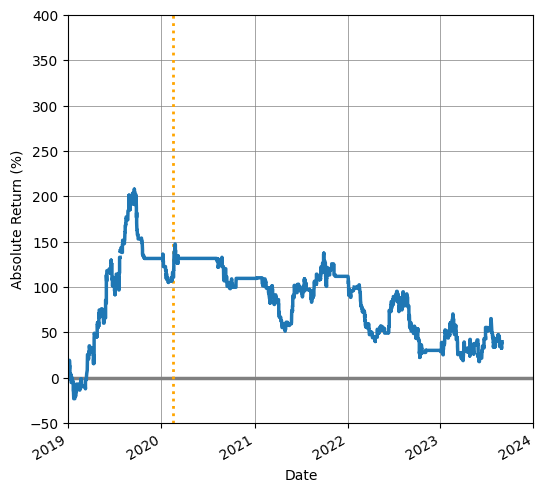

In [5]:
plot_results(testset,show_quarters=False)

In [22]:
from linearmodels import IV2SLS
data2 = data[data['date'] > '2020-02-16'].copy()
# Table 1 Fixed results
# PM
mod = IV2SLS.from_formula('error ~ inverse_avg + wikibuzz + rankdist + C(year)', data2) # Can include RankDist
resid = mod.fit(cov_type='clustered', clusters=data2[['match_id']])
print(resid)

                            OLS Estimation Summary                            
Dep. Variable:                  error   R-squared:                      0.0002
Estimator:                        OLS   Adj. R-squared:                -0.0002
No. Observations:               14949   F-statistic:                    9.8207
Date:                Thu, Dec 07 2023   P-value (F-stat)                0.1324
Time:                        08:53:10   Distribution:                  chi2(6)
Cov. Estimator:             clustered                                         
                                                                              
                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
Intercept          -0.0425     0.0136    -3.1257     0.0018     -0.0692     -0.0159
inverse_avg         0.0337     0